<a href="https://colab.research.google.com/github/mykon23/DL-2020Project/blob/final/Equus8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Equus Dataset

In [1]:
! wget -O Equus.tar.gz https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true

--2020-05-13 04:04:59--  https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz [following]
--2020-05-13 04:04:59--  https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz [following]
--2020-05-13 04:04:59--  https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [0]:
! rm -rf Equus
! tar -zxf Equus.tar.gz

In [0]:
! rm *.tar.gz
! rm -rf train/
! rm -rf validation/
! rm -rf test/

Create the Training Set, Validation Set, and Test Set

In [0]:
import os

##Creates the folder structure of the data staging locations
def set_dataset_loc(loc, sub_dirs):
  if not os.path.exists(loc):
    os.mkdir(loc)
    for s in sub_dirs:
      os.mkdir(os.path.join(loc, s))


dataset_dir = os.path.join('.', 'Equus')
lst_members = os.listdir(dataset_dir)

set_dataset_loc(os.path.join('.', 'train'), lst_members)
set_dataset_loc(os.path.join('.', 'validation'), lst_members)
set_dataset_loc(os.path.join('.', 'test'), lst_members)


In [5]:
##Display distribution of data

for d in os.listdir(dataset_dir):
  print(f'{d}: {len(os.listdir(os.path.join(dataset_dir, d)))}')

Zebra: 339
Donkey: 391
Horse: 314


In [6]:
!ls -lh

total 20K
drwxr-xr-x 5 root root 4.0K Mar 16 03:00 Equus
drwxr-xr-x 1 root root 4.0K May  4 16:26 sample_data
drwxr-xr-x 5 root root 4.0K May 13 04:05 test
drwxr-xr-x 5 root root 4.0K May 13 04:05 train
drwxr-xr-x 5 root root 4.0K May 13 04:05 validation


In [0]:
import shutil

##Populate the staging locations for the data
def stage_data_loc(stage_loc, data_loc, dict_ind):

  ##Create a dictionary containing the images
  dict_images = { k : os.listdir(os.path.join(data_loc, k)) for k in lst_members }

  for k in dict_images.keys():
    for i in range(dict_ind[k][0], dict_ind[k][1]):
      src = os.path.join(os.path.join(data_loc, k), dict_images[k][i])
      dst = os.path.join(os.path.join(stage_loc, k), dict_images[k][i])
      shutil.copyfile(src, dst)

##Keep indices for the data splits
dict_train = {'Donkey': [0, 240], 'Horse': [0, 185], 'Zebra':[0, 185]}
dict_val = {'Donkey': [240, 315], 'Horse': [185, 250], 'Zebra':[185, 249]}
dict_test = {'Donkey': [315, 391], 'Horse': [250, 314],'Zebra': [249, 339]}

stage_data_loc(os.path.join('.', 'train'), dataset_dir, dict_train)
stage_data_loc(os.path.join('.', 'validation'), dataset_dir, dict_val)
stage_data_loc(os.path.join('.', 'test'), dataset_dir, dict_test)


In [8]:
##Count the number of files within each directory
! ls -lh train/*/* | wc -l
! ls -lh validation/*/* | wc -l
! ls -lh test/*/* | wc -l

610
204
230


Define Train and Test Operations

In [9]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

def train_model(model, train, val, model_path):
  ##Set the callbacks
  callback_list = [
  tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    ),
  tf.keras.callbacks.ModelCheckpoint(
      filepath=model_path,
      monitor='val_loss',
      save_best_only=True,
    )
  ]

  ##Train the model
  history = model.fit(
      train['gen'],
      steps_per_epoch=train['steps'],
      epochs=50,
      callbacks = callback_list,
      validation_data=val['gen'],
      validation_steps=val['steps'])
  
  return history

def disp_plot(history, title):
  plt.figure()
  plt.plot(history.history['accuracy'], 'bo', label='Training Acc')
  plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'], 'bo', label='Training Loss')
  plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

def test_model(model, test):
  ##Observe the results of the model against the test data
  test_loss, test_acc = model.evaluate(
    test['gen'],
    steps=test['steps']
  )
  
  return {'accuracy': test_acc, 'loss': test_loss }


Using TensorFlow backend.


Establish Baseline Data Generators

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Visualize the Data

Use as map between images and labels
['Donkey', 'Horse', 'Zebra']


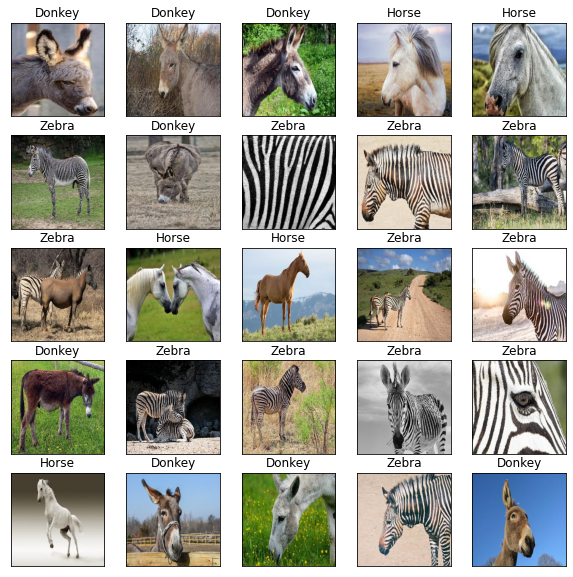

In [11]:
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.preprocessing import image

rows = 5
cols = 5
figure = plt.figure(figsize=(2 * rows, 2 * cols))
##Use as map for mapping image to class
lbls = (sorted(os.listdir('Equus')))
print("Use as map between images and labels")
print(lbls)

##Create dictionary to contain keys and labels
dict_labels = { 2 ** i: lbls[i] for i in range(len(lbls)) }

##Create vector for dot product labeling
mask = np.array([ 2 ** i for i in range(3)])

ax = []
cur_samples = 0
complete = False

for batch in train_generator:
  images = batch[0]
  labels = batch[1]
  for i in range(len(labels)):
    cur_samples += 1
    if cur_samples <= (rows * cols):
      ax.append(figure.add_subplot(rows, cols, cur_samples))
      member = int(np.dot(labels[i], mask))
      ax[-1].set_title(dict_labels[member])
      imgplot = plt.imshow(image.array_to_img( images[i,:,:,:] ) )
    else:
      complete = True
      break
  if complete:
    break
plt.setp(ax, xticks = [], yticks = []) 
plt.show()

Benchmark Candidate

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9

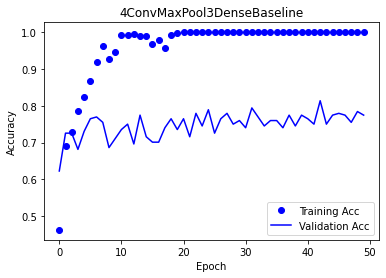

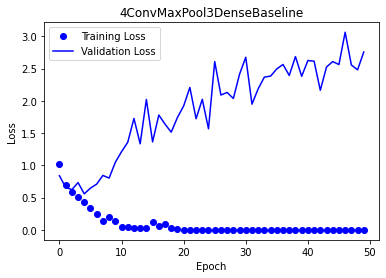

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBaseline.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [13]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 22ms/step - loss: 0.7379 - accuracy: 0.7304
Test: {'accuracy': 0.730434775352478, 'loss': 0.7378838658332825}
17/17 [==============================] - 0s 26ms/step - loss: 0.6688 - accuracy: 0.7304
Val: {'accuracy': 0.7303921580314636, 'loss': 0.6687548160552979}
61/61 [==============================] - 1s 23ms/step - loss: 0.3065 - accuracy: 0.8934
Train: {'accuracy': 0.8934426307678223, 'loss': 0.3064548075199127}


Observe Performance on Hyperparamters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 6)       168       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 6)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 6)       330       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 16)        880       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)       

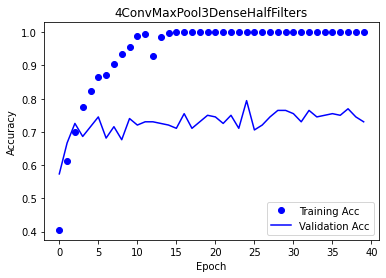

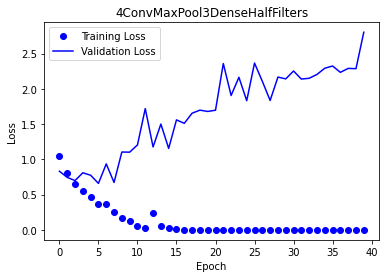

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 6, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 6, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 16, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseHalfFilters.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])


In [15]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 21ms/step - loss: 0.7297 - accuracy: 0.7174
Test: {'accuracy': 0.717391312122345, 'loss': 0.7296982407569885}
17/17 [==============================] - 0s 24ms/step - loss: 0.7116 - accuracy: 0.7255
Val: {'accuracy': 0.7254902124404907, 'loss': 0.7115722298622131}
61/61 [==============================] - 1s 20ms/step - loss: 0.2869 - accuracy: 0.9148
Train: {'accuracy': 0.9147540926933289, 'loss': 0.2868722677230835}


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 32)      3488      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                2952216   
_________________________________________________________________
dense_7 (Dense)              (None, 12)               

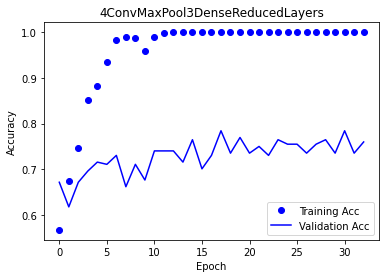

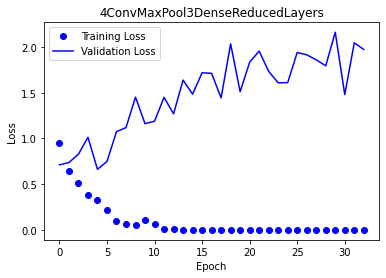

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseReducedLayers.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [17]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.6856 - accuracy: 0.7087
Test: {'accuracy': 0.708695650100708, 'loss': 0.6856238842010498}
17/17 [==============================] - 0s 26ms/step - loss: 0.7205 - accuracy: 0.6961
Val: {'accuracy': 0.6960784196853638, 'loss': 0.7205122113227844}
61/61 [==============================] - 1s 22ms/step - loss: 0.2666 - accuracy: 0.9311
Train: {'accuracy': 0.9311475157737732, 'loss': 0.2665633261203766}


Observe Candidate Model with Data Augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Observe Data Augmentation on Candidate Model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)       

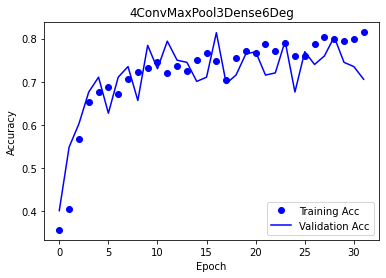

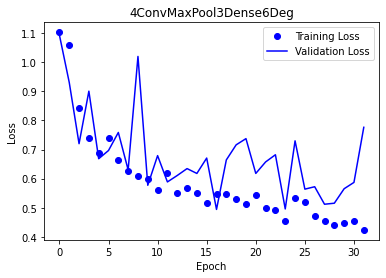

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3Dense6Deg.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [20]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 21ms/step - loss: 0.5737 - accuracy: 0.7565
Test: {'accuracy': 0.7565217614173889, 'loss': 0.5737174153327942}
17/17 [==============================] - 0s 25ms/step - loss: 0.4592 - accuracy: 0.8088
Val: {'accuracy': 0.8088235259056091, 'loss': 0.4591522216796875}
61/61 [==============================] - 8s 134ms/step - loss: 0.5037 - accuracy: 0.8033
Train: {'accuracy': 0.8032786846160889, 'loss': 0.5036866664886475}


Observe L2 Regularization on Candidate Model

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 28, 32)      

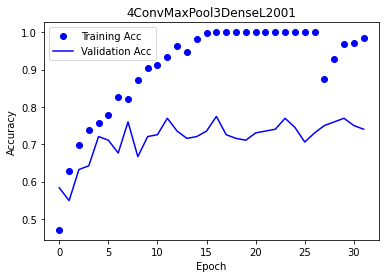

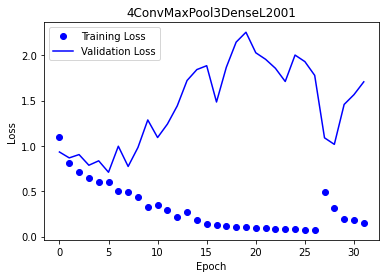

In [42]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.001)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL2001.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [43]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.6947 - accuracy: 0.7435
Test: {'accuracy': 0.7434782385826111, 'loss': 0.6947285532951355}
17/17 [==============================] - 0s 23ms/step - loss: 0.7418 - accuracy: 0.7304
Val: {'accuracy': 0.7303921580314636, 'loss': 0.7418413162231445}
61/61 [==============================] - 1s 21ms/step - loss: 0.5335 - accuracy: 0.8410
Train: {'accuracy': 0.8409836292266846, 'loss': 0.5334663987159729}


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 32)      

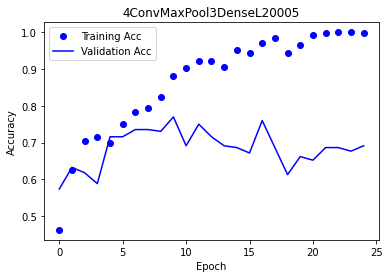

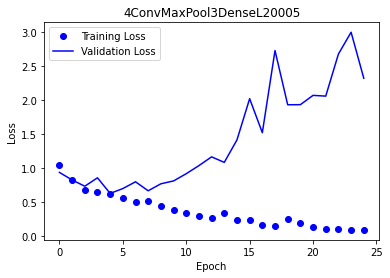

In [44]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.0005)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL20005.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [25]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.6877 - accuracy: 0.7130
Test: {'accuracy': 0.7130434513092041, 'loss': 0.6876556277275085}
17/17 [==============================] - 0s 24ms/step - loss: 0.6958 - accuracy: 0.6912
Val: {'accuracy': 0.6911764740943909, 'loss': 0.6958388686180115}
61/61 [==============================] - 1s 20ms/step - loss: 0.5444 - accuracy: 0.7672
Train: {'accuracy': 0.7672131061553955, 'loss': 0.544352114200592}


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 32)      

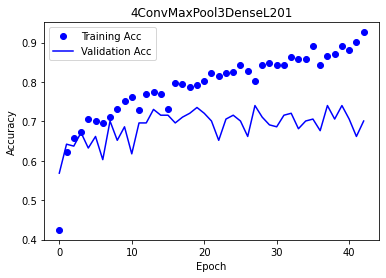

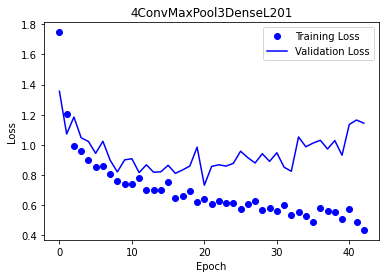

In [37]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

reg = regularizers.L1L2(l2=0.01)

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), kernel_regularizer=reg, activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), kernel_regularizer=reg, activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 12, kernel_regularizer=reg, activation = 'relu' ) )
model.add( Dense( 3, kernel_regularizer=reg, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseL201.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [38]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.8381 - accuracy: 0.7609
Test: {'accuracy': 0.760869562625885, 'loss': 0.8380752801895142}
17/17 [==============================] - 0s 25ms/step - loss: 0.8116 - accuracy: 0.7059
Val: {'accuracy': 0.7058823704719543, 'loss': 0.811552882194519}
61/61 [==============================] - 1s 20ms/step - loss: 0.5985 - accuracy: 0.8197
Train: {'accuracy': 0.8196721076965332, 'loss': 0.5985269546508789}


Observe Dropout with Candidate Model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)       

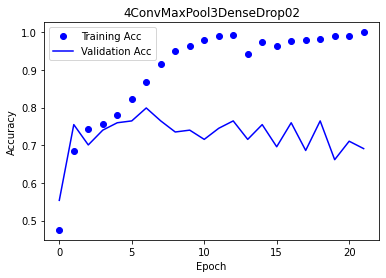

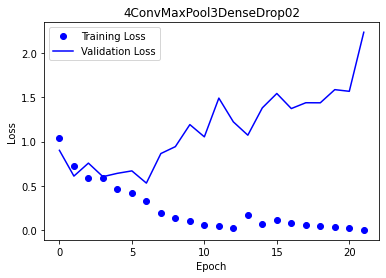

In [28]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.2) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop02.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [29]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 19ms/step - loss: 0.6331 - accuracy: 0.7826
Test: {'accuracy': 0.782608687877655, 'loss': 0.633119523525238}
17/17 [==============================] - 0s 23ms/step - loss: 0.5291 - accuracy: 0.8039
Val: {'accuracy': 0.8039215803146362, 'loss': 0.5291298627853394}
61/61 [==============================] - 1s 20ms/step - loss: 0.2086 - accuracy: 0.9246
Train: {'accuracy': 0.9245901703834534, 'loss': 0.20858247578144073}


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 32)       

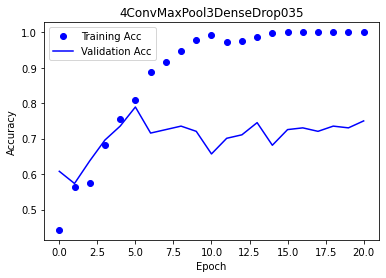

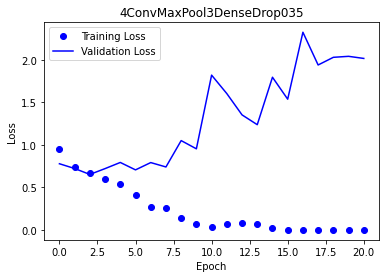

In [30]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.35) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop035.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [31]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.6097 - accuracy: 0.6783
Test: {'accuracy': 0.678260862827301, 'loss': 0.6096533536911011}
17/17 [==============================] - 0s 24ms/step - loss: 0.6658 - accuracy: 0.6029
Val: {'accuracy': 0.6029411554336548, 'loss': 0.6658246517181396}
61/61 [==============================] - 1s 21ms/step - loss: 0.5721 - accuracy: 0.6918
Train: {'accuracy': 0.6918032765388489, 'loss': 0.5721009969711304}


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 32)       

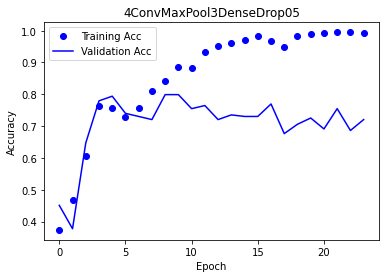

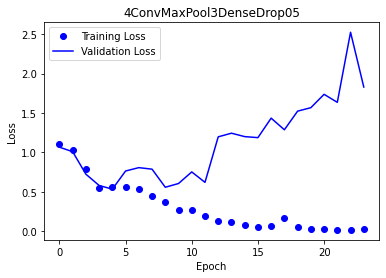

In [32]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.5) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDrop05.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [33]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.6315 - accuracy: 0.7348
Test: {'accuracy': 0.7347826361656189, 'loss': 0.6314526200294495}
17/17 [==============================] - 0s 24ms/step - loss: 0.6197 - accuracy: 0.7941
Val: {'accuracy': 0.7941176295280457, 'loss': 0.6197299361228943}
61/61 [==============================] - 1s 20ms/step - loss: 0.4294 - accuracy: 0.8016
Train: {'accuracy': 0.8016393184661865, 'loss': 0.42944639921188354}


Observe Feature Extraction with Candidate Model Classifier

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 24)                786456    
_________________________________________________________________
dense_31 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 39        
Total params: 15,501,483
Trainable params: 786,795
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
61/61 [==================

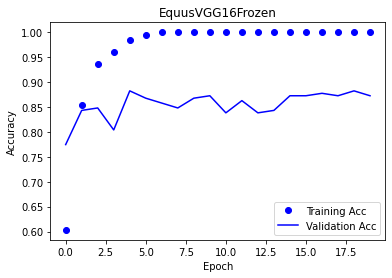

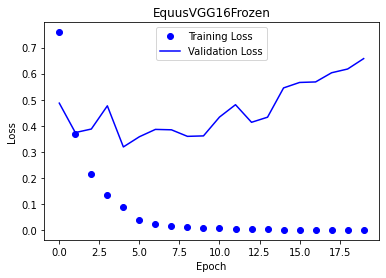

In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

##Set the convolution base as VGG16 and freeze weights
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = 'EquusVGG16Frozen.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [36]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

results = test_model(model, train)
print(f'Train: {results}')

23/23 [==============================] - 1s 41ms/step - loss: 0.2691 - accuracy: 0.8652
Test: {'accuracy': 0.865217387676239, 'loss': 0.26914212107658386}
17/17 [==============================] - 1s 44ms/step - loss: 0.3545 - accuracy: 0.8578
Val: {'accuracy': 0.8578431606292725, 'loss': 0.3545418977737427}
61/61 [==============================] - 3s 42ms/step - loss: 0.0417 - accuracy: 0.9967
Train: {'accuracy': 0.9967213273048401, 'loss': 0.041676074266433716}
